In [1]:
import os
print(os.listdir("../input"))

['Data_Dictionary.xlsx', 'historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'train.csv', '~$Data_Dictionary.xlsx']


In [2]:
kernal_flag=False #True: KernelでDatabaseを使用 False: local環境

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [4]:
import lightgbm as lgb
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
import warnings
import time
import sys
from sklearn.metrics import mean_squared_error

In [5]:
if kernal_flag:
    train = pd.read_csv('../input/elofeatures/train.csv')
    test = pd.read_csv('../input/elofeatures/test.csv')    
else:
    train = pd.read_csv('./save/train.csv')
    test = pd.read_csv('./save/test.csv')
target = train['target']
del train['target']

In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,first_active_year,non_transactions_count,non_category_1_sum,non_category_1_mean,non_category_2_sum,non_category_2_mean,non_category_3_sum,non_category_3_mean,non_merchant_id_nunique,non_merchant_category_id_nunique,non_state_id_nunique,non_city_id_nunique,non_card_id_size,non_subsector_id_nunique,non_purchase_amount_sum,non_purchase_amount_mean,non_purchase_amount_max,non_purchase_amount_min,non_purchase_amount_std,non_purchase_amount_skew,non_installments_sum,non_installments_mean,non_installments_max,non_installments_min,non_installments_std,non_installments_skew,non_purchase_date_ptp,non_purchase_date_mean,non_purchase_date_max,non_purchase_date_min,non_purchase_date_std,non_purchase_date_skew,non_purchase_month_mean,non_purchase_month_max,non_purchase_month_min,non_purchase_month_std,non_purchase_month_skew,non_purchase_weekday_mean,non_purchase_weekday_max,non_purchase_weekday_min,non_purchase_weekday_std,non_purchase_weekday_skew,non_purchase_weekofyear_mean,non_purchase_weekofyear_max,non_purchase_weekofyear_min,non_purchase_weekofyear_std,non_purchase_weekofyear_skew,non_purchase_day_mean,non_purchase_day_max,non_purchase_day_min,non_purchase_day_std,non_purchase_day_skew,non_purchase_hour_mean,non_purchase_hour_max,non_purchase_hour_min,non_purchase_hour_std,non_purchase_hour_skew,non_duration_mean,non_duration_min,non_duration_max,non_duration_std,non_duration_skew,non_amount_month_ratio_mean,non_amount_month_ratio_min,non_amount_month_ratio_max,non_amount_month_ratio_std,non_amount_month_ratio_skew,non_duration_nonlag_mean,non_duration_nonlag_min,non_duration_nonlag_max,non_duration_nonlag_std,non_duration_nonlag_skew,non_amount_month_ratio_nonlag_mean,non_amount_month_ratio_nonlag_min,non_amount_month_ratio_nonlag_max,non_amount_month_ratio_nonlag_std,non_amount_month_ratio_nonlag_skew,non_price_mean,non_price_max,non_price_min,non_price_std,non_price_skew,non_month_lag_mean,non_month_lag_max,non_month_lag_min,non_month_lag_std,non_month_lag_skew,non_month_diff_mean,non_month_diff_max,non_month_diff_min,non_month_diff_std,non_month_diff_skew,non_month_diff_nonlag_mean,non_month_diff_nonlag_max,non_month_diff_nonlag_min,non_month_diff_nonlag_std,non_month_diff_nonlag_skew,non_purchase_date_diff,non_purchase_date_average,non_purchase_date_uptonow,non_purchase_date_uptomin,non_CLV,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_sum,auth_category_2_mean,auth_category_3_sum,auth_category_3_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_card_id_size,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_skew,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_skew,auth_purchase_date_ptp,auth_purchase_date_mean,auth_purchase_date_max,auth_purchase_date_min,auth_purchase_date_std,auth_purchase_date_skew,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_skew,auth_purchase_weekday_mean,auth_purchase_weekday_max,auth_purchase_weekday_min,auth_purchase_weekday_std,auth_purchase_weekday_skew,auth_purchase_weekofyear_mean,auth_purchase_weekofyear_max,auth_purchase_weekofyear_min,auth_purchase_weekofyear_std,auth_purchase_weekofyear_skew,auth_purchase_day_mean,auth_purchase_day_max,auth_purchase_day_min,auth_purchase_day_std,auth_purchase_day_skew,auth_purchase_hour_mean,auth_purchase_hour_max,auth_purchase_hour_min,auth_purchase_hour_std,auth_purchase_hour_skew,auth_duration_mean,auth_duration_min,auth_duration_max,auth_duration_std,auth_duration_skew,auth_amount_month_ratio_mean,auth_amount_month_ratio_min,auth_amount_month_ratio_max,auth_amount_month_ratio_std,auth_amount_month_ratio_skew,auth_duration_n

In [7]:
features = [c for c in train.columns if c not in ['card_id']]
features

['first_active_month',
 'feature_1',
 'feature_2',
 'feature_3',
 'elapsed_time',
 'first_active_year',
 'non_transactions_count',
 'non_category_1_sum',
 'non_category_1_mean',
 'non_category_2_sum',
 'non_category_2_mean',
 'non_category_3_sum',
 'non_category_3_mean',
 'non_merchant_id_nunique',
 'non_merchant_category_id_nunique',
 'non_state_id_nunique',
 'non_city_id_nunique',
 'non_card_id_size',
 'non_subsector_id_nunique',
 'non_purchase_amount_sum',
 'non_purchase_amount_mean',
 'non_purchase_amount_max',
 'non_purchase_amount_min',
 'non_purchase_amount_std',
 'non_purchase_amount_skew',
 'non_installments_sum',
 'non_installments_mean',
 'non_installments_max',
 'non_installments_min',
 'non_installments_std',
 'non_installments_skew',
 'non_purchase_date_ptp',
 'non_purchase_date_mean',
 'non_purchase_date_max',
 'non_purchase_date_min',
 'non_purchase_date_std',
 'non_purchase_date_skew',
 'non_purchase_month_mean',
 'non_purchase_month_max',
 'non_purchase_month_min',
 '

In [8]:
categorical_feats = ['feature_1','feature_2', 'feature_3','first_active_year','first_active_month']

In [9]:
param = {'num_leaves': 199, 'min_data_in_leaf': 83, 'max_depth': 6, 'learning_rate': 0.014947324172640617, 'feature_fraction': 0.7759702308199912, 'bagging_freq': 4, 'bagging_fraction': 0.8204154703953661, 'lambda_l1': 0.1370963903036045,
         "boosting": "gbdt",
         "metric": 'rmse',
         'objective':'regression',
         "random_state": 133,
         "verbosity": -1}

In [10]:
start = time.time()
feature_importance_df = pd.DataFrame()

In [11]:
oof_1 = np.zeros(len(train))
predictions_1 = np.zeros(len(test))
folds = KFold(n_splits=12, shuffle=True, random_state=15)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 500)
    
    oof_1[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_1 += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63909	valid_1's rmse: 3.67344
[200]	training's rmse: 3.57796	valid_1's rmse: 3.6459
[300]	training's rmse: 3.54616	valid_1's rmse: 3.63491
[400]	training's rmse: 3.52233	valid_1's rmse: 3.63011
[500]	training's rmse: 3.50086	valid_1's rmse: 3.62868
[600]	training's rmse: 3.48105	valid_1's rmse: 3.62783
[700]	training's rmse: 3.46179	valid_1's rmse: 3.62716
[800]	training's rmse: 3.44066	valid_1's rmse: 3.62721
[900]	training's rmse: 3.4215	valid_1's rmse: 3.62633
[1000]	training's rmse: 3.40341	valid_1's rmse: 3.62747
[1100]	training's rmse: 3.38737	valid_1's rmse: 3.62768
[1200]	training's rmse: 3.36942	valid_1's rmse: 3.62808
[1300]	training's rmse: 3.35226	valid_1's rmse: 3.6286
[1400]	training's rmse: 3.33595	valid_1's rmse: 3.6284
Early stopping, best iteration is:
[927]	training's rmse: 3.41719	valid_1's rmse: 3.62594
fold n°1


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63408	valid_1's rmse: 3.71429
[200]	training's rmse: 3.57418	valid_1's rmse: 3.69455
[300]	training's rmse: 3.54367	valid_1's rmse: 3.68948
[400]	training's rmse: 3.51759	valid_1's rmse: 3.6876
[500]	training's rmse: 3.49351	valid_1's rmse: 3.68631
[600]	training's rmse: 3.4737	valid_1's rmse: 3.68672
[700]	training's rmse: 3.45286	valid_1's rmse: 3.68649
[800]	training's rmse: 3.43341	valid_1's rmse: 3.68757
[900]	training's rmse: 3.41443	valid_1's rmse: 3.68839
[1000]	training's rmse: 3.39469	valid_1's rmse: 3.69007
Early stopping, best iteration is:
[519]	training's rmse: 3.49015	valid_1's rmse: 3.68608
fold n°2


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63026	valid_1's rmse: 3.75713
[200]	training's rmse: 3.57129	valid_1's rmse: 3.73044
[300]	training's rmse: 3.53992	valid_1's rmse: 3.72372
[400]	training's rmse: 3.5176	valid_1's rmse: 3.72153
[500]	training's rmse: 3.49867	valid_1's rmse: 3.7191
[600]	training's rmse: 3.48106	valid_1's rmse: 3.71901
[700]	training's rmse: 3.46193	valid_1's rmse: 3.71872
[800]	training's rmse: 3.44147	valid_1's rmse: 3.7185
[900]	training's rmse: 3.42189	valid_1's rmse: 3.71926
[1000]	training's rmse: 3.4029	valid_1's rmse: 3.71914
[1100]	training's rmse: 3.3855	valid_1's rmse: 3.71906
[1200]	training's rmse: 3.36677	valid_1's rmse: 3.71875
Early stopping, best iteration is:
[720]	training's rmse: 3.45827	valid_1's rmse: 3.71817
fold n°3


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.65081	valid_1's rmse: 3.55542
[200]	training's rmse: 3.5908	valid_1's rmse: 3.53207
[300]	training's rmse: 3.55646	valid_1's rmse: 3.52447
[400]	training's rmse: 3.53301	valid_1's rmse: 3.52274
[500]	training's rmse: 3.50967	valid_1's rmse: 3.52114
[600]	training's rmse: 3.48898	valid_1's rmse: 3.52038
[700]	training's rmse: 3.46727	valid_1's rmse: 3.51887
[800]	training's rmse: 3.44867	valid_1's rmse: 3.51835
[900]	training's rmse: 3.43198	valid_1's rmse: 3.51854
[1000]	training's rmse: 3.41329	valid_1's rmse: 3.51866
[1100]	training's rmse: 3.39733	valid_1's rmse: 3.51887
[1200]	training's rmse: 3.37872	valid_1's rmse: 3.51886
[1300]	training's rmse: 3.36033	valid_1's rmse: 3.51917
Early stopping, best iteration is:
[836]	training's rmse: 3.4412	valid_1's rmse: 3.51762
fold n°4


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64326	valid_1's rmse: 3.6265
[200]	training's rmse: 3.58344	valid_1's rmse: 3.60218
[300]	training's rmse: 3.55197	valid_1's rmse: 3.59549
[400]	training's rmse: 3.52549	valid_1's rmse: 3.59152
[500]	training's rmse: 3.50319	valid_1's rmse: 3.59051
[600]	training's rmse: 3.48312	valid_1's rmse: 3.59045
[700]	training's rmse: 3.46392	valid_1's rmse: 3.59031
[800]	training's rmse: 3.44278	valid_1's rmse: 3.58985
[900]	training's rmse: 3.42271	valid_1's rmse: 3.58956
[1000]	training's rmse: 3.40502	valid_1's rmse: 3.58807
[1100]	training's rmse: 3.38484	valid_1's rmse: 3.58795
[1200]	training's rmse: 3.36801	valid_1's rmse: 3.58757
[1300]	training's rmse: 3.35065	valid_1's rmse: 3.5886
[1400]	training's rmse: 3.33376	valid_1's rmse: 3.58807
[1500]	training's rmse: 3.31833	valid_1's rmse: 3.588
[1600]	training's rmse: 3.30409	valid_1's rmse: 3.58828
Early stopping, best iteration is:
[1156]	training's r

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64692	valid_1's rmse: 3.562
[200]	training's rmse: 3.5859	valid_1's rmse: 3.54369
[300]	training's rmse: 3.55567	valid_1's rmse: 3.538
[400]	training's rmse: 3.52956	valid_1's rmse: 3.53478
[500]	training's rmse: 3.50692	valid_1's rmse: 3.53369
[600]	training's rmse: 3.48676	valid_1's rmse: 3.53302
[700]	training's rmse: 3.46585	valid_1's rmse: 3.53208
[800]	training's rmse: 3.44546	valid_1's rmse: 3.53179
[900]	training's rmse: 3.42628	valid_1's rmse: 3.5312
[1000]	training's rmse: 3.40764	valid_1's rmse: 3.53152
[1100]	training's rmse: 3.39212	valid_1's rmse: 3.53114
[1200]	training's rmse: 3.37168	valid_1's rmse: 3.53045
[1300]	training's rmse: 3.35404	valid_1's rmse: 3.5322
[1400]	training's rmse: 3.33769	valid_1's rmse: 3.53321
[1500]	training's rmse: 3.32259	valid_1's rmse: 3.53304
[1600]	training's rmse: 3.30469	valid_1's rmse: 3.53359
Early stopping, best iteration is:
[1190]	training's rmse

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63257	valid_1's rmse: 3.75893
[200]	training's rmse: 3.56928	valid_1's rmse: 3.73229
[300]	training's rmse: 3.53732	valid_1's rmse: 3.72442
[400]	training's rmse: 3.51408	valid_1's rmse: 3.72081
[500]	training's rmse: 3.49102	valid_1's rmse: 3.7179
[600]	training's rmse: 3.47228	valid_1's rmse: 3.71531
[700]	training's rmse: 3.45167	valid_1's rmse: 3.71552
[800]	training's rmse: 3.43382	valid_1's rmse: 3.71538
[900]	training's rmse: 3.4152	valid_1's rmse: 3.71476
[1000]	training's rmse: 3.39573	valid_1's rmse: 3.71501
[1100]	training's rmse: 3.37861	valid_1's rmse: 3.71504
[1200]	training's rmse: 3.36145	valid_1's rmse: 3.71421
[1300]	training's rmse: 3.34528	valid_1's rmse: 3.71553
[1400]	training's rmse: 3.3271	valid_1's rmse: 3.7155
Early stopping, best iteration is:
[928]	training's rmse: 3.40909	valid_1's rmse: 3.71405
fold n°7


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.61912	valid_1's rmse: 3.90255
[200]	training's rmse: 3.55974	valid_1's rmse: 3.87671
[300]	training's rmse: 3.52739	valid_1's rmse: 3.86894
[400]	training's rmse: 3.50384	valid_1's rmse: 3.86595
[500]	training's rmse: 3.48144	valid_1's rmse: 3.86575
[600]	training's rmse: 3.45905	valid_1's rmse: 3.8649
[700]	training's rmse: 3.44067	valid_1's rmse: 3.86497
[800]	training's rmse: 3.41975	valid_1's rmse: 3.86297
[900]	training's rmse: 3.40013	valid_1's rmse: 3.86143
[1000]	training's rmse: 3.38152	valid_1's rmse: 3.8615
[1100]	training's rmse: 3.36108	valid_1's rmse: 3.86255
[1200]	training's rmse: 3.34362	valid_1's rmse: 3.86159
[1300]	training's rmse: 3.32483	valid_1's rmse: 3.86206
[1400]	training's rmse: 3.30785	valid_1's rmse: 3.86113
[1500]	training's rmse: 3.29214	valid_1's rmse: 3.86258
[1600]	training's rmse: 3.27556	valid_1's rmse: 3.86311
[1700]	training's rmse: 3.26119	valid_1's rmse: 3.86

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63878	valid_1's rmse: 3.65691
[200]	training's rmse: 3.57614	valid_1's rmse: 3.63829
[300]	training's rmse: 3.54136	valid_1's rmse: 3.63331
[400]	training's rmse: 3.51607	valid_1's rmse: 3.63111
[500]	training's rmse: 3.49369	valid_1's rmse: 3.63022
[600]	training's rmse: 3.47461	valid_1's rmse: 3.62954
[700]	training's rmse: 3.45521	valid_1's rmse: 3.6292
[800]	training's rmse: 3.43301	valid_1's rmse: 3.62911
[900]	training's rmse: 3.41433	valid_1's rmse: 3.62866
[1000]	training's rmse: 3.39528	valid_1's rmse: 3.62879
[1100]	training's rmse: 3.37504	valid_1's rmse: 3.62902
[1200]	training's rmse: 3.35617	valid_1's rmse: 3.62884
Early stopping, best iteration is:
[721]	training's rmse: 3.45014	valid_1's rmse: 3.62816
fold n°9


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63032	valid_1's rmse: 3.76824
[200]	training's rmse: 3.57234	valid_1's rmse: 3.74609
[300]	training's rmse: 3.54045	valid_1's rmse: 3.73947
[400]	training's rmse: 3.51526	valid_1's rmse: 3.73529
[500]	training's rmse: 3.49435	valid_1's rmse: 3.73547
[600]	training's rmse: 3.47305	valid_1's rmse: 3.73455
[700]	training's rmse: 3.45363	valid_1's rmse: 3.73474
[800]	training's rmse: 3.43394	valid_1's rmse: 3.73569
[900]	training's rmse: 3.41467	valid_1's rmse: 3.7368
[1000]	training's rmse: 3.39496	valid_1's rmse: 3.73667
Early stopping, best iteration is:
[592]	training's rmse: 3.47482	valid_1's rmse: 3.73413
fold n°10


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63487	valid_1's rmse: 3.72551
[200]	training's rmse: 3.57398	valid_1's rmse: 3.71126
[300]	training's rmse: 3.54136	valid_1's rmse: 3.70588
[400]	training's rmse: 3.51535	valid_1's rmse: 3.70356
[500]	training's rmse: 3.49652	valid_1's rmse: 3.7045
[600]	training's rmse: 3.47249	valid_1's rmse: 3.70496
[700]	training's rmse: 3.4534	valid_1's rmse: 3.70498
[800]	training's rmse: 3.43415	valid_1's rmse: 3.70421
Early stopping, best iteration is:
[366]	training's rmse: 3.52551	valid_1's rmse: 3.70322
fold n°11


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64893	valid_1's rmse: 3.54087
[200]	training's rmse: 3.59075	valid_1's rmse: 3.51831
[300]	training's rmse: 3.5593	valid_1's rmse: 3.51238
[400]	training's rmse: 3.53633	valid_1's rmse: 3.5104
[500]	training's rmse: 3.51388	valid_1's rmse: 3.50814
[600]	training's rmse: 3.49383	valid_1's rmse: 3.50936
[700]	training's rmse: 3.47198	valid_1's rmse: 3.50938
[800]	training's rmse: 3.4533	valid_1's rmse: 3.51024
[900]	training's rmse: 3.43536	valid_1's rmse: 3.51157
[1000]	training's rmse: 3.41894	valid_1's rmse: 3.51198
Early stopping, best iteration is:
[521]	training's rmse: 3.50914	valid_1's rmse: 3.50758


NameError: name 'oof' is not defined

In [12]:
sub_df = pd.DataFrame({"card_id":train["card_id"].values})
sub_df["target"] = oof_1
sub_df.to_csv("train_stack_fold.csv", index=False)
print("CV score: {:<8.5f}".format(mean_squared_error(oof_1, target)**0.5))

CV score: 3.65242 


In [13]:
# CV score: 3.65549
# CV score: 3.65546 
# CV score: 3.65416 

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


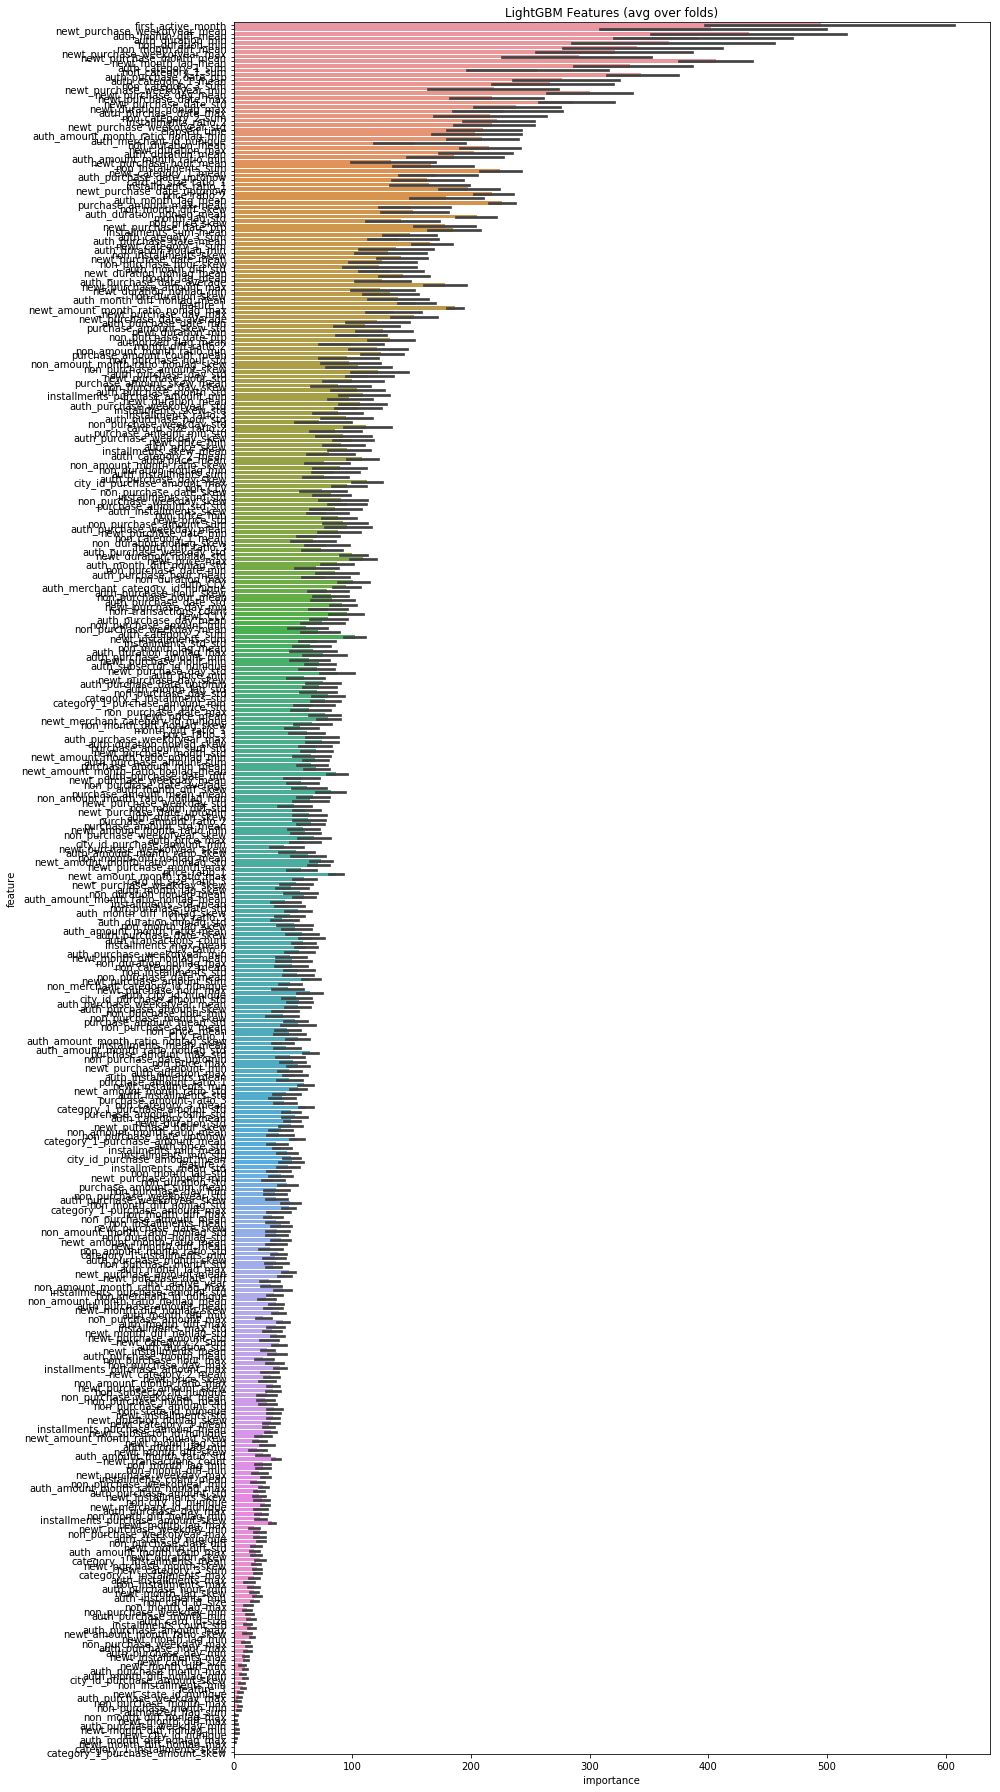

In [15]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances_fold.png')

In [16]:
best_features.groupby('feature')['importance'].mean().sort_values(ascending=False)

feature
first_active_month                     495.333333
auth_month_diff_mean                   433.916667
newt_month_lag_mean                    406.333333
newt_purchase_weekofyear_mean          402.416667
auth_duration_min                      391.166667
non_duration_min                       367.000000
auth_purchase_date_ptp                 343.416667
non_month_diff_mean                    340.000000
auth_category_1_sum                    334.250000
newt_purchase_weekofyear_max           320.916667
newt_purchase_day_mean                 300.333333
newt_purchase_month_mean               290.833333
newt_purchase_date_std                 286.000000
auth_category_1_mean                   276.583333
non_category_3_sum                     266.916667
non_category_1_sum                     256.000000
newt_duration_nonlag_max               238.166667
auth_purchase_date_max                 228.083333
purchase_amount_max_mean               226.000000
newt_category_1_mean                   224

In [18]:
oof_2 = np.zeros(len(train))
predictions_2 = np.zeros(len(test))
folds = KFold(n_splits=12, shuffle=True, random_state=50)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 500)
    
    oof_2[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_2 += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

sub_df = pd.DataFrame({"card_id":train["card_id"].values})
sub_df["target"] = oof_2
sub_df.to_csv("train_stack_Sfold.csv", index=False)
print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold n°0


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.62488	valid_1's rmse: 3.83468
[200]	training's rmse: 3.56414	valid_1's rmse: 3.80554
[300]	training's rmse: 3.53054	valid_1's rmse: 3.795
[400]	training's rmse: 3.50641	valid_1's rmse: 3.79171
[500]	training's rmse: 3.48657	valid_1's rmse: 3.79017
[600]	training's rmse: 3.46786	valid_1's rmse: 3.78919
[700]	training's rmse: 3.44686	valid_1's rmse: 3.78915
[800]	training's rmse: 3.4271	valid_1's rmse: 3.78813
[900]	training's rmse: 3.40936	valid_1's rmse: 3.78919
[1000]	training's rmse: 3.39018	valid_1's rmse: 3.78813
[1100]	training's rmse: 3.37167	valid_1's rmse: 3.78861
[1200]	training's rmse: 3.35418	valid_1's rmse: 3.78825
Early stopping, best iteration is:
[791]	training's rmse: 3.42944	valid_1's rmse: 3.78756
fold n°1


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64209	valid_1's rmse: 3.63509
[200]	training's rmse: 3.58269	valid_1's rmse: 3.61741
[300]	training's rmse: 3.54929	valid_1's rmse: 3.6131
[400]	training's rmse: 3.52381	valid_1's rmse: 3.61186
[500]	training's rmse: 3.50133	valid_1's rmse: 3.61001
[600]	training's rmse: 3.48202	valid_1's rmse: 3.61006
[700]	training's rmse: 3.4653	valid_1's rmse: 3.61035
[800]	training's rmse: 3.44438	valid_1's rmse: 3.6119
[900]	training's rmse: 3.42496	valid_1's rmse: 3.61149
[1000]	training's rmse: 3.40545	valid_1's rmse: 3.61028
Early stopping, best iteration is:
[532]	training's rmse: 3.49476	valid_1's rmse: 3.60983
fold n°2


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.61938	valid_1's rmse: 3.89491
[200]	training's rmse: 3.56138	valid_1's rmse: 3.86482
[300]	training's rmse: 3.52982	valid_1's rmse: 3.85814
[400]	training's rmse: 3.50616	valid_1's rmse: 3.85614
[500]	training's rmse: 3.48492	valid_1's rmse: 3.85559
[600]	training's rmse: 3.46468	valid_1's rmse: 3.85613
[700]	training's rmse: 3.44564	valid_1's rmse: 3.85678
[800]	training's rmse: 3.42731	valid_1's rmse: 3.85821
[900]	training's rmse: 3.40849	valid_1's rmse: 3.85953
Early stopping, best iteration is:
[468]	training's rmse: 3.49153	valid_1's rmse: 3.85547
fold n°3


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64102	valid_1's rmse: 3.65681
[200]	training's rmse: 3.58007	valid_1's rmse: 3.63105
[300]	training's rmse: 3.54651	valid_1's rmse: 3.62297
[400]	training's rmse: 3.52366	valid_1's rmse: 3.61963
[500]	training's rmse: 3.5019	valid_1's rmse: 3.61817
[600]	training's rmse: 3.48207	valid_1's rmse: 3.61687
[700]	training's rmse: 3.46304	valid_1's rmse: 3.61655
[800]	training's rmse: 3.44334	valid_1's rmse: 3.61665
[900]	training's rmse: 3.42363	valid_1's rmse: 3.618
[1000]	training's rmse: 3.40715	valid_1's rmse: 3.61779
[1100]	training's rmse: 3.39002	valid_1's rmse: 3.61924
[1200]	training's rmse: 3.37264	valid_1's rmse: 3.62
Early stopping, best iteration is:
[716]	training's rmse: 3.45933	valid_1's rmse: 3.61612
fold n°4


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64155	valid_1's rmse: 3.64129
[200]	training's rmse: 3.58218	valid_1's rmse: 3.61098
[300]	training's rmse: 3.5511	valid_1's rmse: 3.60034
[400]	training's rmse: 3.52624	valid_1's rmse: 3.59466
[500]	training's rmse: 3.50669	valid_1's rmse: 3.59301
[600]	training's rmse: 3.48604	valid_1's rmse: 3.5917
[700]	training's rmse: 3.46507	valid_1's rmse: 3.58959
[800]	training's rmse: 3.44541	valid_1's rmse: 3.58992
[900]	training's rmse: 3.4284	valid_1's rmse: 3.58808
[1000]	training's rmse: 3.41252	valid_1's rmse: 3.5884
[1100]	training's rmse: 3.39457	valid_1's rmse: 3.58928
[1200]	training's rmse: 3.37733	valid_1's rmse: 3.58857
[1300]	training's rmse: 3.36002	valid_1's rmse: 3.5885
[1400]	training's rmse: 3.34372	valid_1's rmse: 3.58905
[1500]	training's rmse: 3.32597	valid_1's rmse: 3.58804
[1600]	training's rmse: 3.31108	valid_1's rmse: 3.58818
[1700]	training's rmse: 3.2962	valid_1's rmse: 3.58722


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64116	valid_1's rmse: 3.64209
[200]	training's rmse: 3.57939	valid_1's rmse: 3.62697
[300]	training's rmse: 3.54374	valid_1's rmse: 3.62429
[400]	training's rmse: 3.51856	valid_1's rmse: 3.62266
[500]	training's rmse: 3.49927	valid_1's rmse: 3.62197
[600]	training's rmse: 3.48083	valid_1's rmse: 3.62309
[700]	training's rmse: 3.46121	valid_1's rmse: 3.62359
[800]	training's rmse: 3.43902	valid_1's rmse: 3.62375
[900]	training's rmse: 3.4189	valid_1's rmse: 3.62282
[1000]	training's rmse: 3.39959	valid_1's rmse: 3.62206
Early stopping, best iteration is:
[506]	training's rmse: 3.49788	valid_1's rmse: 3.62193
fold n°6


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63984	valid_1's rmse: 3.65797
[200]	training's rmse: 3.57869	valid_1's rmse: 3.63379
[300]	training's rmse: 3.54389	valid_1's rmse: 3.62549
[400]	training's rmse: 3.51807	valid_1's rmse: 3.62138
[500]	training's rmse: 3.49633	valid_1's rmse: 3.61843
[600]	training's rmse: 3.47526	valid_1's rmse: 3.61719
[700]	training's rmse: 3.45464	valid_1's rmse: 3.61616
[800]	training's rmse: 3.43562	valid_1's rmse: 3.61594
[900]	training's rmse: 3.41662	valid_1's rmse: 3.61613
[1000]	training's rmse: 3.39894	valid_1's rmse: 3.61698
[1100]	training's rmse: 3.38098	valid_1's rmse: 3.61694
[1200]	training's rmse: 3.36191	valid_1's rmse: 3.61802
Early stopping, best iteration is:
[768]	training's rmse: 3.44109	valid_1's rmse: 3.61514
fold n°7


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63056	valid_1's rmse: 3.7666
[200]	training's rmse: 3.57105	valid_1's rmse: 3.74267
[300]	training's rmse: 3.53929	valid_1's rmse: 3.7354
[400]	training's rmse: 3.51554	valid_1's rmse: 3.73101
[500]	training's rmse: 3.49448	valid_1's rmse: 3.72879
[600]	training's rmse: 3.47109	valid_1's rmse: 3.728
[700]	training's rmse: 3.44955	valid_1's rmse: 3.72765
[800]	training's rmse: 3.4319	valid_1's rmse: 3.72832
[900]	training's rmse: 3.41478	valid_1's rmse: 3.72822
[1000]	training's rmse: 3.39725	valid_1's rmse: 3.72873
[1100]	training's rmse: 3.38143	valid_1's rmse: 3.72908
[1200]	training's rmse: 3.36325	valid_1's rmse: 3.72989
Early stopping, best iteration is:
[744]	training's rmse: 3.44271	valid_1's rmse: 3.72687
fold n°8


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63832	valid_1's rmse: 3.66608
[200]	training's rmse: 3.57579	valid_1's rmse: 3.64446
[300]	training's rmse: 3.54323	valid_1's rmse: 3.63966
[400]	training's rmse: 3.51887	valid_1's rmse: 3.63612
[500]	training's rmse: 3.49908	valid_1's rmse: 3.63421
[600]	training's rmse: 3.47636	valid_1's rmse: 3.63265
[700]	training's rmse: 3.45802	valid_1's rmse: 3.63312
[800]	training's rmse: 3.43892	valid_1's rmse: 3.63406
[900]	training's rmse: 3.42131	valid_1's rmse: 3.63313
[1000]	training's rmse: 3.40466	valid_1's rmse: 3.6345
Early stopping, best iteration is:
[583]	training's rmse: 3.48058	valid_1's rmse: 3.63248
fold n°9


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64595	valid_1's rmse: 3.59171
[200]	training's rmse: 3.58893	valid_1's rmse: 3.56799
[300]	training's rmse: 3.55652	valid_1's rmse: 3.5599
[400]	training's rmse: 3.5322	valid_1's rmse: 3.55688
[500]	training's rmse: 3.5102	valid_1's rmse: 3.55416
[600]	training's rmse: 3.49055	valid_1's rmse: 3.55202
[700]	training's rmse: 3.46962	valid_1's rmse: 3.55081
[800]	training's rmse: 3.45083	valid_1's rmse: 3.5506
[900]	training's rmse: 3.4346	valid_1's rmse: 3.54843
[1000]	training's rmse: 3.41674	valid_1's rmse: 3.54859
[1100]	training's rmse: 3.39681	valid_1's rmse: 3.5486
[1200]	training's rmse: 3.37861	valid_1's rmse: 3.54904
[1300]	training's rmse: 3.36228	valid_1's rmse: 3.54806
[1400]	training's rmse: 3.34329	valid_1's rmse: 3.5478
[1500]	training's rmse: 3.32621	valid_1's rmse: 3.5474
[1600]	training's rmse: 3.30908	valid_1's rmse: 3.54766
[1700]	training's rmse: 3.29201	valid_1's rmse: 3.5478
[18

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63669	valid_1's rmse: 3.68969
[200]	training's rmse: 3.57621	valid_1's rmse: 3.6749
[300]	training's rmse: 3.54247	valid_1's rmse: 3.67212
[400]	training's rmse: 3.52024	valid_1's rmse: 3.6685
[500]	training's rmse: 3.49993	valid_1's rmse: 3.66809
[600]	training's rmse: 3.48002	valid_1's rmse: 3.66779
[700]	training's rmse: 3.46002	valid_1's rmse: 3.66806
[800]	training's rmse: 3.44138	valid_1's rmse: 3.66893
[900]	training's rmse: 3.42419	valid_1's rmse: 3.66933
[1000]	training's rmse: 3.40681	valid_1's rmse: 3.66886
[1100]	training's rmse: 3.38724	valid_1's rmse: 3.66859
Early stopping, best iteration is:
[642]	training's rmse: 3.4707	valid_1's rmse: 3.66738
fold n°11


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64708	valid_1's rmse: 3.56878
[200]	training's rmse: 3.58797	valid_1's rmse: 3.54861
[300]	training's rmse: 3.55434	valid_1's rmse: 3.54515
[400]	training's rmse: 3.52935	valid_1's rmse: 3.54374
[500]	training's rmse: 3.50676	valid_1's rmse: 3.54348
[600]	training's rmse: 3.48493	valid_1's rmse: 3.54411
[700]	training's rmse: 3.46513	valid_1's rmse: 3.54444
[800]	training's rmse: 3.44545	valid_1's rmse: 3.54531
[900]	training's rmse: 3.42754	valid_1's rmse: 3.54556
Early stopping, best iteration is:
[476]	training's rmse: 3.51266	valid_1's rmse: 3.5432
CV score: 3.65194 


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


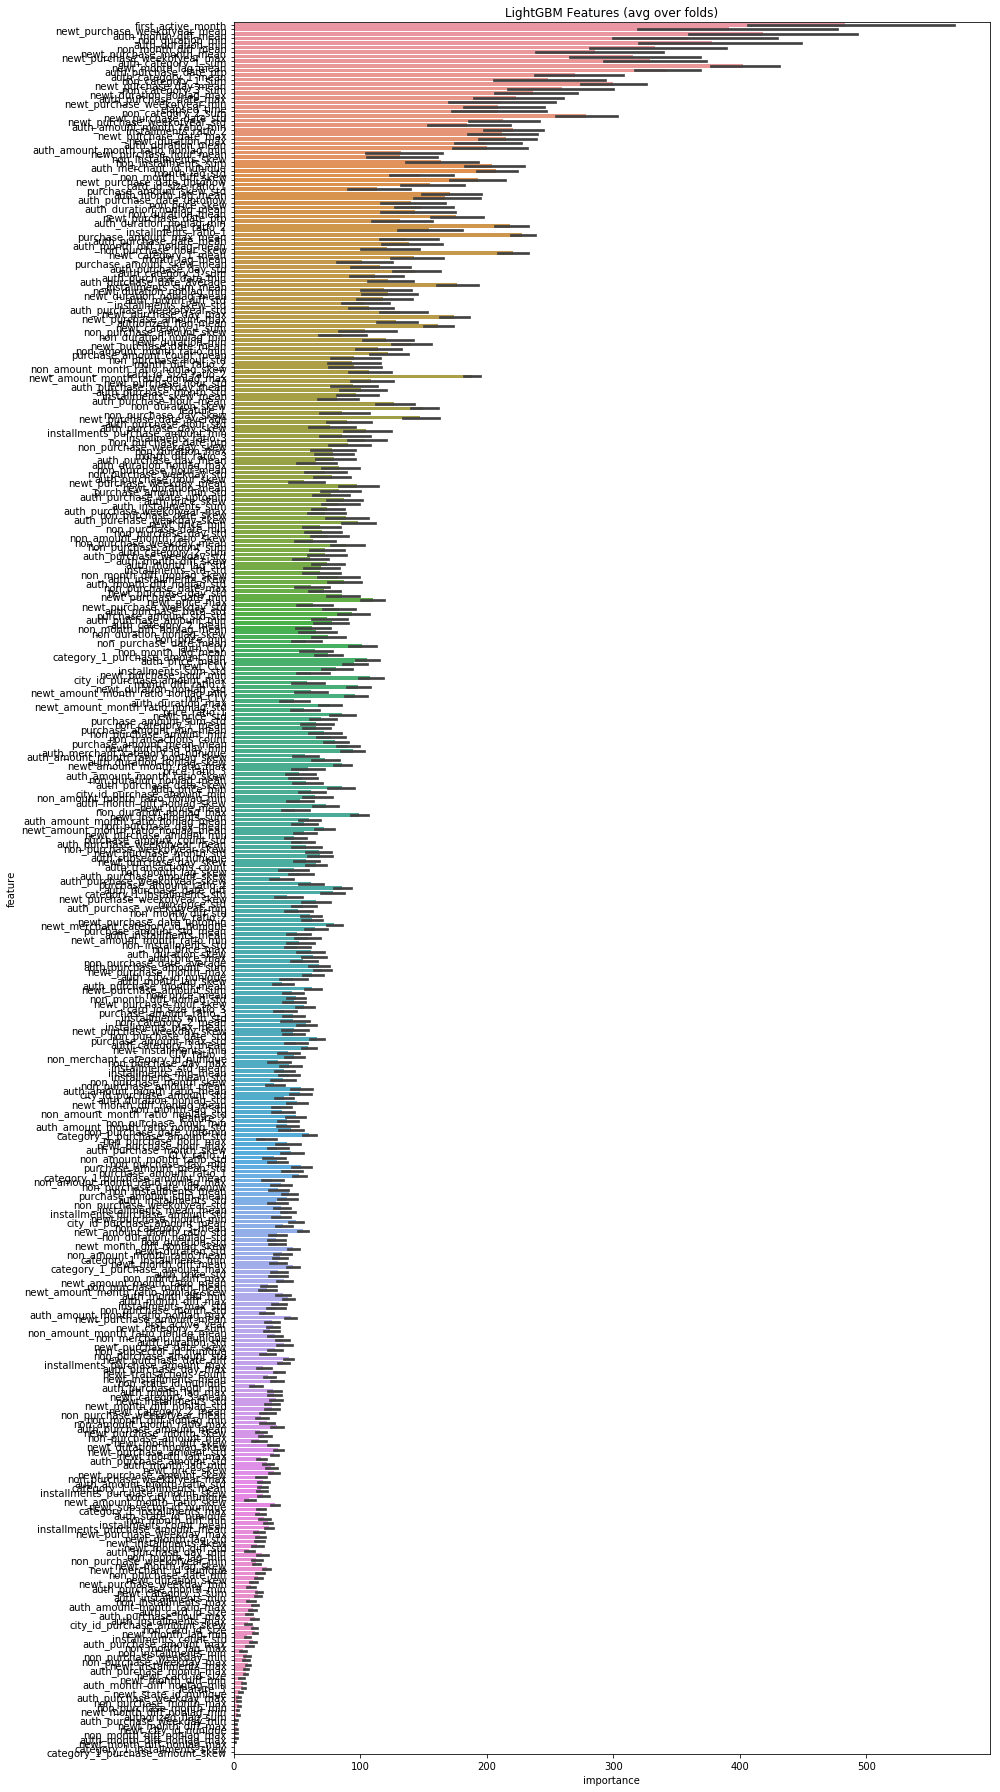

In [19]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances_Sfold.png')

In [20]:
best_features.groupby('feature')['importance'].mean().sort_values(ascending=False)

feature
first_active_month                     482.916667
auth_month_diff_mean                   418.583333
newt_month_lag_mean                    402.875000
newt_purchase_weekofyear_mean          391.125000
auth_duration_min                      378.208333
non_duration_min                       359.125000
auth_purchase_date_ptp                 342.375000
non_month_diff_mean                    332.625000
auth_category_1_sum                    328.916667
newt_purchase_weekofyear_max           316.000000
newt_purchase_day_mean                 299.583333
newt_purchase_month_mean               285.958333
newt_purchase_date_std                 278.416667
auth_category_1_mean                   269.500000
non_category_3_sum                     259.500000
non_category_1_sum                     248.125000
newt_duration_nonlag_max               236.916667
purchase_amount_max_mean               227.958333
auth_purchase_date_max                 223.375000
newt_category_1_mean                   220

In [22]:
oof_3 = np.zeros(len(train))
predictions_3 = np.zeros(len(test))
folds = KFold(n_splits=12, shuffle=True, random_state=258)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 500)
    
    oof_3[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_3 += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

sub_df = pd.DataFrame({"card_id":train["card_id"].values})
sub_df["target"] = oof_3
sub_df.to_csv("train_stack_Rfold.csv", index=False)
print("CV score: {:<8.5f}".format(mean_squared_error(oof_3, target)**0.5))

fold n°0


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64418	valid_1's rmse: 3.64248
[200]	training's rmse: 3.58176	valid_1's rmse: 3.61523
[300]	training's rmse: 3.54883	valid_1's rmse: 3.6064
[400]	training's rmse: 3.52491	valid_1's rmse: 3.60095
[500]	training's rmse: 3.5048	valid_1's rmse: 3.5985
[600]	training's rmse: 3.48482	valid_1's rmse: 3.59716
[700]	training's rmse: 3.46486	valid_1's rmse: 3.59866
[800]	training's rmse: 3.44683	valid_1's rmse: 3.59935
[900]	training's rmse: 3.42752	valid_1's rmse: 3.60054
[1000]	training's rmse: 3.4096	valid_1's rmse: 3.59954
Early stopping, best iteration is:
[592]	training's rmse: 3.48622	valid_1's rmse: 3.59698
fold n°1


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.6248	valid_1's rmse: 3.83452
[200]	training's rmse: 3.56212	valid_1's rmse: 3.81547
[300]	training's rmse: 3.52961	valid_1's rmse: 3.81107
[400]	training's rmse: 3.50591	valid_1's rmse: 3.81029
[500]	training's rmse: 3.48532	valid_1's rmse: 3.81001
[600]	training's rmse: 3.46468	valid_1's rmse: 3.81146
[700]	training's rmse: 3.44386	valid_1's rmse: 3.81276
[800]	training's rmse: 3.42327	valid_1's rmse: 3.81436
[900]	training's rmse: 3.40618	valid_1's rmse: 3.81506
Early stopping, best iteration is:
[488]	training's rmse: 3.48691	valid_1's rmse: 3.80954
fold n°2


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.62314	valid_1's rmse: 3.83731
[200]	training's rmse: 3.56443	valid_1's rmse: 3.81081
[300]	training's rmse: 3.5315	valid_1's rmse: 3.80193
[400]	training's rmse: 3.50615	valid_1's rmse: 3.7983
[500]	training's rmse: 3.48514	valid_1's rmse: 3.79758
[600]	training's rmse: 3.46531	valid_1's rmse: 3.79588
[700]	training's rmse: 3.4466	valid_1's rmse: 3.7957
[800]	training's rmse: 3.42875	valid_1's rmse: 3.79602
[900]	training's rmse: 3.41282	valid_1's rmse: 3.79491
[1000]	training's rmse: 3.39467	valid_1's rmse: 3.79423
[1100]	training's rmse: 3.37498	valid_1's rmse: 3.79502
[1200]	training's rmse: 3.35772	valid_1's rmse: 3.79568
[1300]	training's rmse: 3.33867	valid_1's rmse: 3.79584
[1400]	training's rmse: 3.3212	valid_1's rmse: 3.79483
Early stopping, best iteration is:
[944]	training's rmse: 3.40524	valid_1's rmse: 3.79417
fold n°3


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.63611	valid_1's rmse: 3.70555
[200]	training's rmse: 3.57502	valid_1's rmse: 3.68362
[300]	training's rmse: 3.54119	valid_1's rmse: 3.676
[400]	training's rmse: 3.51919	valid_1's rmse: 3.67531
[500]	training's rmse: 3.49893	valid_1's rmse: 3.67395
[600]	training's rmse: 3.47683	valid_1's rmse: 3.67409
[700]	training's rmse: 3.45792	valid_1's rmse: 3.67405
[800]	training's rmse: 3.43906	valid_1's rmse: 3.67415
[900]	training's rmse: 3.41865	valid_1's rmse: 3.67405
[1000]	training's rmse: 3.40143	valid_1's rmse: 3.67502
[1100]	training's rmse: 3.38261	valid_1's rmse: 3.67663
[1200]	training's rmse: 3.36531	valid_1's rmse: 3.67804
Early stopping, best iteration is:
[768]	training's rmse: 3.44521	valid_1's rmse: 3.6734
fold n°4


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.65207	valid_1's rmse: 3.5371
[200]	training's rmse: 3.59191	valid_1's rmse: 3.509
[300]	training's rmse: 3.55968	valid_1's rmse: 3.49986
[400]	training's rmse: 3.53383	valid_1's rmse: 3.49551
[500]	training's rmse: 3.51181	valid_1's rmse: 3.49446
[600]	training's rmse: 3.49163	valid_1's rmse: 3.49335
[700]	training's rmse: 3.47208	valid_1's rmse: 3.49283
[800]	training's rmse: 3.45476	valid_1's rmse: 3.4917
[900]	training's rmse: 3.43915	valid_1's rmse: 3.4917
[1000]	training's rmse: 3.42119	valid_1's rmse: 3.49131
[1100]	training's rmse: 3.40169	valid_1's rmse: 3.49032
[1200]	training's rmse: 3.38362	valid_1's rmse: 3.49019
[1300]	training's rmse: 3.3667	valid_1's rmse: 3.4901
[1400]	training's rmse: 3.35156	valid_1's rmse: 3.4911
[1500]	training's rmse: 3.33459	valid_1's rmse: 3.49148
[1600]	training's rmse: 3.31751	valid_1's rmse: 3.4922
Early stopping, best iteration is:
[1177]	training's rmse: 

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.62399	valid_1's rmse: 3.84058
[200]	training's rmse: 3.56089	valid_1's rmse: 3.81819
[300]	training's rmse: 3.5284	valid_1's rmse: 3.81415
[400]	training's rmse: 3.50382	valid_1's rmse: 3.81266
[500]	training's rmse: 3.48297	valid_1's rmse: 3.81198
[600]	training's rmse: 3.46278	valid_1's rmse: 3.8126
[700]	training's rmse: 3.44237	valid_1's rmse: 3.81373
[800]	training's rmse: 3.42389	valid_1's rmse: 3.81439
[900]	training's rmse: 3.40562	valid_1's rmse: 3.816
[1000]	training's rmse: 3.38464	valid_1's rmse: 3.81726
Early stopping, best iteration is:
[525]	training's rmse: 3.47779	valid_1's rmse: 3.81154
fold n°6


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.65711	valid_1's rmse: 3.46153
[200]	training's rmse: 3.59532	valid_1's rmse: 3.44173
[300]	training's rmse: 3.56364	valid_1's rmse: 3.43616
[400]	training's rmse: 3.53777	valid_1's rmse: 3.43331
[500]	training's rmse: 3.51489	valid_1's rmse: 3.43171
[600]	training's rmse: 3.4937	valid_1's rmse: 3.43133
[700]	training's rmse: 3.47284	valid_1's rmse: 3.4316
[800]	training's rmse: 3.45557	valid_1's rmse: 3.43089
[900]	training's rmse: 3.43779	valid_1's rmse: 3.43016
[1000]	training's rmse: 3.41965	valid_1's rmse: 3.43121
[1100]	training's rmse: 3.40138	valid_1's rmse: 3.43204
[1200]	training's rmse: 3.38312	valid_1's rmse: 3.43211
[1300]	training's rmse: 3.36602	valid_1's rmse: 3.43066
[1400]	training's rmse: 3.34804	valid_1's rmse: 3.42974
[1500]	training's rmse: 3.33027	valid_1's rmse: 3.43016
[1600]	training's rmse: 3.31432	valid_1's rmse: 3.43098
[1700]	training's rmse: 3.29794	valid_1's rmse: 3.43

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.66106	valid_1's rmse: 3.4093
[200]	training's rmse: 3.59932	valid_1's rmse: 3.39252
[300]	training's rmse: 3.56933	valid_1's rmse: 3.38826
[400]	training's rmse: 3.54352	valid_1's rmse: 3.38653
[500]	training's rmse: 3.52135	valid_1's rmse: 3.3869
[600]	training's rmse: 3.49982	valid_1's rmse: 3.38714
[700]	training's rmse: 3.47893	valid_1's rmse: 3.38755
[800]	training's rmse: 3.461	valid_1's rmse: 3.38769
Early stopping, best iteration is:
[387]	training's rmse: 3.54683	valid_1's rmse: 3.38632
fold n°8


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.62271	valid_1's rmse: 3.87131
[200]	training's rmse: 3.56199	valid_1's rmse: 3.83765
[300]	training's rmse: 3.53039	valid_1's rmse: 3.82536
[400]	training's rmse: 3.50714	valid_1's rmse: 3.82076
[500]	training's rmse: 3.48456	valid_1's rmse: 3.81837
[600]	training's rmse: 3.46449	valid_1's rmse: 3.81818
[700]	training's rmse: 3.44518	valid_1's rmse: 3.81929
[800]	training's rmse: 3.42496	valid_1's rmse: 3.81873
[900]	training's rmse: 3.40649	valid_1's rmse: 3.81865
[1000]	training's rmse: 3.38736	valid_1's rmse: 3.81807
[1100]	training's rmse: 3.36873	valid_1's rmse: 3.8173
[1200]	training's rmse: 3.35113	valid_1's rmse: 3.8169
[1300]	training's rmse: 3.33466	valid_1's rmse: 3.81751
[1400]	training's rmse: 3.3165	valid_1's rmse: 3.81703
[1500]	training's rmse: 3.30071	valid_1's rmse: 3.81822
[1600]	training's rmse: 3.28511	valid_1's rmse: 3.81788
[1700]	training's rmse: 3.26785	valid_1's rmse: 3.817

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.64436	valid_1's rmse: 3.58877
[200]	training's rmse: 3.5841	valid_1's rmse: 3.57148
[300]	training's rmse: 3.55123	valid_1's rmse: 3.56835
[400]	training's rmse: 3.52613	valid_1's rmse: 3.5675
[500]	training's rmse: 3.50314	valid_1's rmse: 3.56628
[600]	training's rmse: 3.48324	valid_1's rmse: 3.56682
[700]	training's rmse: 3.46532	valid_1's rmse: 3.56738
[800]	training's rmse: 3.44596	valid_1's rmse: 3.56719
[900]	training's rmse: 3.42627	valid_1's rmse: 3.56813
Early stopping, best iteration is:
[472]	training's rmse: 3.50963	valid_1's rmse: 3.56589
fold n°10


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.6354	valid_1's rmse: 3.71508
[200]	training's rmse: 3.57407	valid_1's rmse: 3.69236
[300]	training's rmse: 3.54034	valid_1's rmse: 3.68552
[400]	training's rmse: 3.5149	valid_1's rmse: 3.68224
[500]	training's rmse: 3.49099	valid_1's rmse: 3.67988
[600]	training's rmse: 3.47106	valid_1's rmse: 3.67925
[700]	training's rmse: 3.45243	valid_1's rmse: 3.68006
[800]	training's rmse: 3.43501	valid_1's rmse: 3.68012
[900]	training's rmse: 3.41668	valid_1's rmse: 3.67967
[1000]	training's rmse: 3.399	valid_1's rmse: 3.68027
Early stopping, best iteration is:
[580]	training's rmse: 3.47458	valid_1's rmse: 3.67866
fold n°11


C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Hiroyuki\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.62878	valid_1's rmse: 3.78388
[200]	training's rmse: 3.56936	valid_1's rmse: 3.76064
[300]	training's rmse: 3.53816	valid_1's rmse: 3.75356
[400]	training's rmse: 3.51508	valid_1's rmse: 3.75145
[500]	training's rmse: 3.4934	valid_1's rmse: 3.74947
[600]	training's rmse: 3.47336	valid_1's rmse: 3.74917
[700]	training's rmse: 3.45306	valid_1's rmse: 3.74836
[800]	training's rmse: 3.43428	valid_1's rmse: 3.74893
[900]	training's rmse: 3.41504	valid_1's rmse: 3.74935
[1000]	training's rmse: 3.39621	valid_1's rmse: 3.74823
[1100]	training's rmse: 3.37559	valid_1's rmse: 3.74727
[1200]	training's rmse: 3.3586	valid_1's rmse: 3.74753
[1300]	training's rmse: 3.3376	valid_1's rmse: 3.74829
[1400]	training's rmse: 3.31954	valid_1's rmse: 3.75035
[1500]	training's rmse: 3.30117	valid_1's rmse: 3.75026
Early stopping, best iteration is:
[1096]	training's rmse: 3.37628	valid_1's rmse: 3.74694
CV score: 3.65295 

C:\Users\Hiroyuki\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


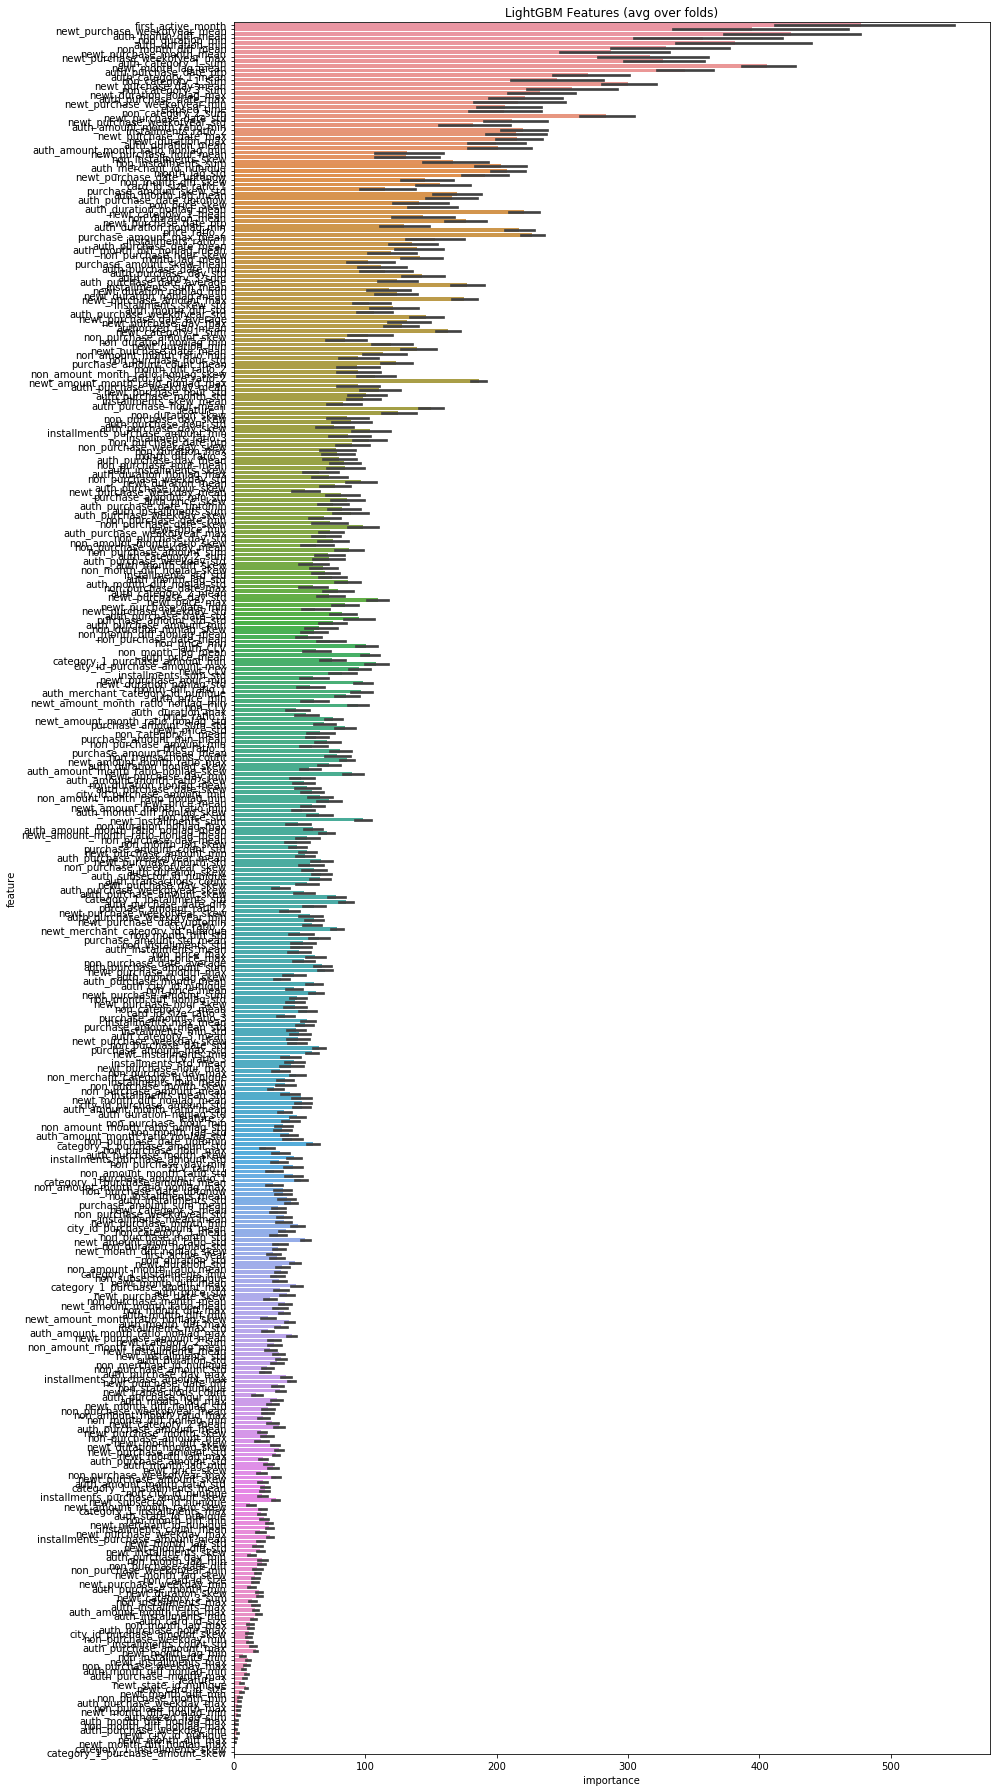

In [23]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances_Rfold.png')

In [24]:
best_features.groupby('feature')['importance'].mean().sort_values(ascending=False)

feature
first_active_month                     477.333333
auth_month_diff_mean                   424.361111
newt_month_lag_mean                    405.416667
newt_purchase_weekofyear_mean          394.222222
auth_duration_min                      381.666667
non_duration_min                       357.305556
auth_purchase_date_ptp                 343.388889
non_month_diff_mean                    329.222222
auth_category_1_sum                    326.944444
newt_purchase_weekofyear_max           316.972222
newt_purchase_day_mean                 299.805556
newt_purchase_month_mean               286.972222
newt_purchase_date_std                 282.944444
auth_category_1_mean                   269.333333
non_category_3_sum                     257.444444
non_category_1_sum                     245.805556
newt_duration_nonlag_max               232.916667
purchase_amount_max_mean               226.583333
auth_purchase_date_max                 221.777778
newt_category_1_mean                   220

#### stacking

In [25]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof_1,oof_2,oof_3]).transpose()
test_stack = np.vstack([predictions_1, predictions_2,predictions_3]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_stack = BayesianRidge()
    clf_stack.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_stack.predict(val_data)
    predictions_stack += clf_stack.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4


3.6493971947459394

In [26]:
# clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
# clf.fit(oof.reshape(-1,1), target) 
# predictions=clf.predict(predictions)

#### submission

In [27]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_stack
sub_df.to_csv("submit.csv", index=False)